# Finger Sign Detection using CNN

In [1]:
import h5py
import time
import torch
import matplotlib.pyplot as plt
import math

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cpu


## Extract Dataset

In [3]:
def h5_to_tensor(h5_file_path):
    dataset_tensor = {}
    
    with h5py.File(h5_file_path, 'r') as h5:
        keys = list(h5.keys())

        for key in keys:
            data = h5[key][:]
            dataset_tensor[key] = torch.from_numpy(data)

    return dataset_tensor

### Training Data

In [4]:
training_data = h5_to_tensor("dataset/Signs_Data_Training.h5")

print(training_data.keys())

dict_keys(['list_classes', 'train_set_x', 'train_set_y'])


In [5]:
X_train = training_data["train_set_x"].to(device)
y_train = training_data["train_set_y"].to(device)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([1080, 64, 64, 3])
y_train shape: torch.Size([1080])


### Test data

In [6]:
testing_data = h5_to_tensor("dataset/Signs_Data_Testing.h5")

print(testing_data.keys())

dict_keys(['list_classes', 'test_set_x', 'test_set_y'])


In [7]:
X_test = testing_data["test_set_x"].to(device)
y_test = testing_data["test_set_y"].to(device)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: torch.Size([120, 64, 64, 3])
y_test shape: torch.Size([120])


## Data Preprocessing

In [8]:
# Check if there is any NaN values

print(X_train.isnan().sum())
print(y_train.isnan().sum())

tensor(0)
tensor(0)


In [9]:
# Set of classes 
# According to data, there are data which belongs to either one of 6 classes: [0, 1, 2, 3, 4, 5]

y_train.unique()

tensor([0, 1, 2, 3, 4, 5])

In [10]:
# Display images

def display_images(images, labels):
    cols = 4
    rows = math.ceil(len(images) / cols)
    plt.figure(figsize=(20, 10))
    index = 0

    for x in zip(images, labels):
        image = x[0]
        label = x[1]
        plt.subplot(rows, cols, index + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        # plt.axis("off")
        index += 1

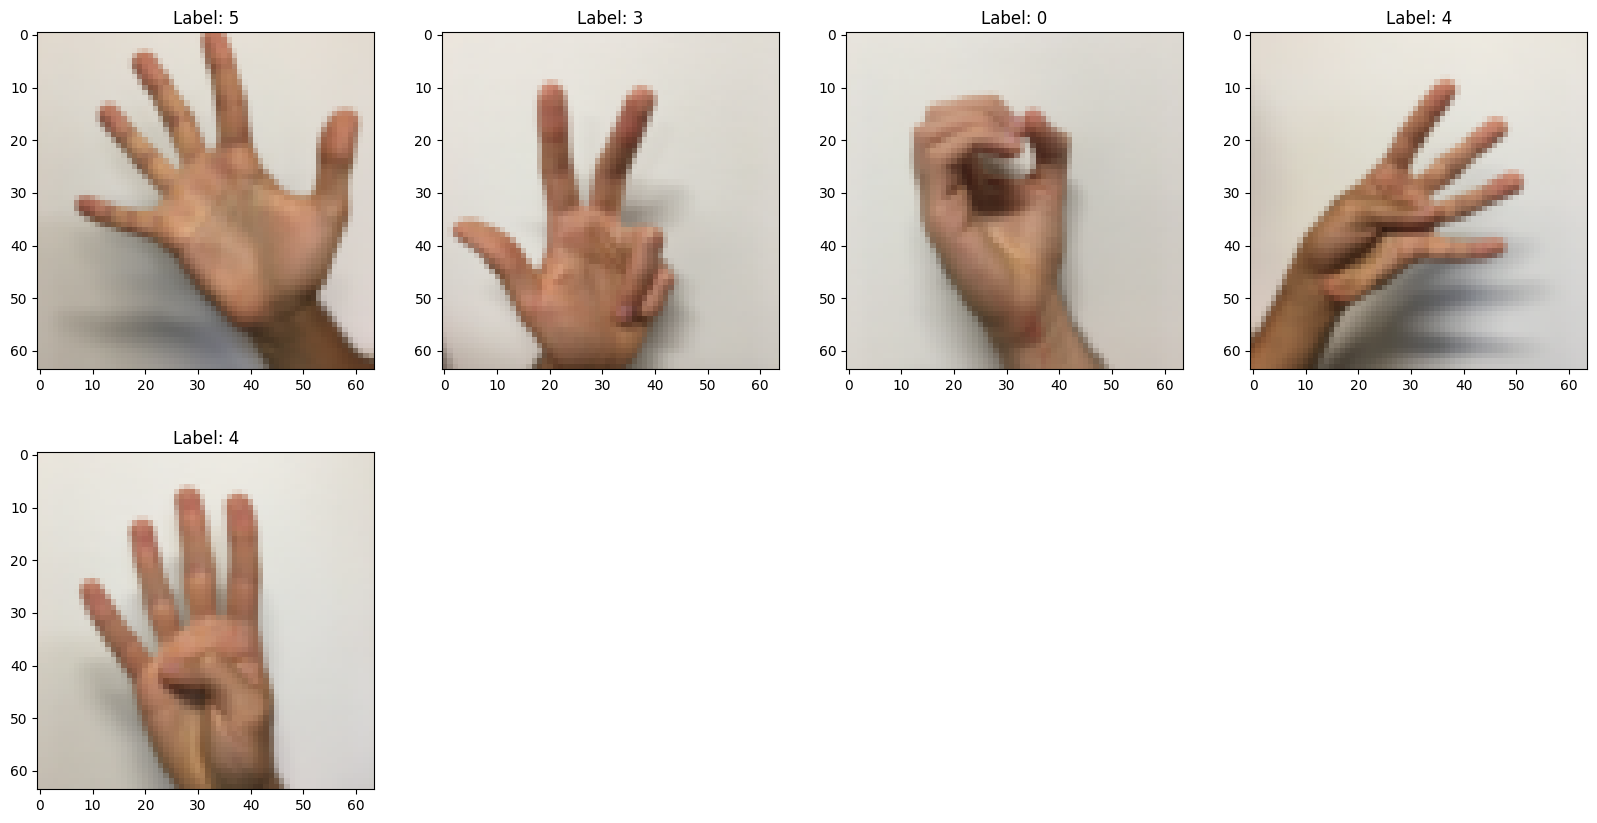

In [11]:
import random

indices = [random.randint(0, X_train.shape[0]) for _ in range(5)]
images = [X_train[index] for index in indices]
labels = [y_train[index] for index in indices]

display_images(images, labels)

## Custom Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

## Build CNN Model

In [13]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Input image size: 64 * 64 * 3 (3 channels)

        # Layer Set 1: Convolutional Layer -> ReLU Layer -> Pooling Layer
        self.conv_layer_1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()

        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer Set 2: Conv Layer -> ReLU Layer -> Max Pool Layer
        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()

        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected layers: Input (509 neurons) -> FC 1 (256 neurons) with ReLU -> FC 2 (128 neurons) with ReLU -> FC 3/Output (6 classes)
        self.fc_1 = nn.Linear(in_features=16*16*64, out_features=256)
        self.fc_1_relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.2)

        self.fc_2 = nn.Linear(in_features=256, out_features=128)
        self.fc_2_relu = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.2)

        self.fc_3 = nn.Linear(in_features=128, out_features=6)

    def forward(self, X):
        # Conv Layer 1
        out = self.conv_layer_1(X)
        out = self.bn_1(out)
        out = self.relu_1(out)

        out = self.max_pool_1(out)

        # Conv Layer 2
        out = self.conv_layer_2(out)
        out = self.bn_2(out)
        out = self.relu_2(out)

        out = self.max_pool_2(out)
        
        # Flatten
        out = out.reshape(out.size(0), -1)

        # FC Layers
        out = self.fc_1(out)
        out = self.fc_1_relu(out)
        out = self.dropout_1(out)

        out = self.fc_2(out)
        out = self.fc_2_relu(out)
        out = self.dropout_2(out)

        out = self.fc_3(out)

        return out

## Set Hyperparameters

In [14]:
batch_size = 32
total_epochs = 100
learning_rate = 0.001

## Model Training

In [15]:
cnn_model = CNNModel()

In [16]:
error = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)

In [17]:
train_dataset = CustomDataset(X_train, y_train)

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [18]:
num_of_iterations = X_train.shape[0] // batch_size

count = 0
loss_list = []
iteration_list = []

training_start_time = time.time()

for epoch in range(total_epochs):
    for i, (images, labels) in enumerate(train_data):
        images = images.float()
        images = images.permute(0, 3, 1, 2)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn_model.forward(images)

        # Calculate loss
        loss = error(output, labels)

        # Backpropagation and calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1
        loss_list.append(loss)
        iteration_list.append(count)

        if i % 4 == 0:
            print(f"Epoch: [{epoch + 1}/{total_epochs}], step: [{i + 1}/{num_of_iterations}], loss: {loss.data:.4f}")

training_end_time = time.time()

print(f"\nTotal training time: {training_end_time - training_start_time} seconds")

Epoch: [1/100], step: [1/33], loss: 1.7865
Epoch: [1/100], step: [5/33], loss: 1.7857
Epoch: [1/100], step: [9/33], loss: 1.8096
Epoch: [1/100], step: [13/33], loss: 1.7944
Epoch: [1/100], step: [17/33], loss: 1.8311
Epoch: [1/100], step: [21/33], loss: 1.7995
Epoch: [1/100], step: [25/33], loss: 1.7778
Epoch: [1/100], step: [29/33], loss: 1.7771
Epoch: [1/100], step: [33/33], loss: 1.7664
Epoch: [2/100], step: [1/33], loss: 1.7696
Epoch: [2/100], step: [5/33], loss: 1.7695
Epoch: [2/100], step: [9/33], loss: 1.7380
Epoch: [2/100], step: [13/33], loss: 1.7440
Epoch: [2/100], step: [17/33], loss: 1.7280
Epoch: [2/100], step: [21/33], loss: 1.7541
Epoch: [2/100], step: [25/33], loss: 1.7486
Epoch: [2/100], step: [29/33], loss: 1.7251
Epoch: [2/100], step: [33/33], loss: 1.7483
Epoch: [3/100], step: [1/33], loss: 1.7302
Epoch: [3/100], step: [5/33], loss: 1.6886
Epoch: [3/100], step: [9/33], loss: 1.6992
Epoch: [3/100], step: [13/33], loss: 1.7153
Epoch: [3/100], step: [17/33], loss: 1.72

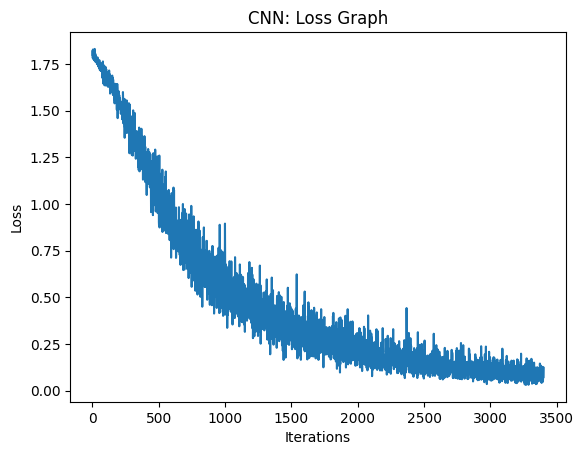

In [19]:
# Loss Graph

loss_list_numpy = [loss.detach().cpu().numpy() for loss in loss_list]

plt.plot(iteration_list, loss_list_numpy)

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.title("CNN: Loss Graph")

plt.show()

## Model Evaluation

In [20]:
test_dataset = CustomDataset(X_test, y_test)

test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
with torch.no_grad():
    total_test = 0
    total_correct = 0

    for i, (images, labels) in enumerate(test_data):
        images = images.float()
        images = images.permute(0, 3, 1, 2)

        output = cnn_model.forward(images)

        _, predictions = torch.max(output, 1)

        total_correct += (predictions == labels).sum().item()
        total_test += labels.shape[0]

print(f"Total correct predictions: {total_correct}")
print(f"Total samples: {total_test}")
print(f"Accuracy: {total_correct / total_test * 100:.3f}%")

Total correct predictions: 113
Total samples: 120
Accuracy: 94.167%
